In [7]:
import sys
import numpy
import pickle
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None;
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from conversion_cosmology import Cosmology
import corner
from tqdm import tqdm
import json

import sys
sys.path.append("../../sampler/runs/multiPDB_betaSplit_brokenG_1_full/")
from sampler.runs.multiPDB_betaSplit_brokenG_1_full.model_vector import model_vector

path = "../conversion_scripts/multiPDB_betaSplit_brokenG/conversion_dict_inv.json"

with open(path, "r") as f:
    conv = json.load(f)

conv["w"] = "w"

PLANCK_2018_Ho = 2.1816926176539463e-18 ### CGS
PLANCK_2018_OmegaMatter = 0.3158
PLANCK_2018_OmegaLambda = 1. - PLANCK_2018_OmegaMatter
PLANCK_2018_OmegaRadiation = 0.

### define units in SI
C_SI =  299792458.0
PC_SI = 3.085677581491367e+16
MPC_SI = PC_SI * 1e6
G_SI = 6.6743e-11
MSUN_SI = 1.9884099021470415e+30

### define units in CGS
G_CGS = G_SI * 1e+3
C_CGS = C_SI * 1e2
PC_CGS = PC_SI * 1e2
MPC_CGS = MPC_SI * 1e2

In [9]:
# event_samples = pd.read_csv('GW190814_C01:IMRPhenomXPHM.csv.gz')
event_samples = pd.read_csv("GW230529_Combined_PHM_highSpin.csv.gz")
population_samples = pd.read_csv(f"../grid_wide_sig_chi_amax/population0.4.csv.gz")
# population_samples = pd.read_csv("../grid_gamma_low_debug/Farah2022-i-PDB.csv.gz")

requirements = [
    'm_break', 'alpha_1', 'alpha_2', 'gamma_low', 'eta_low', 'gamma_high', 'eta_high', 'A',
    'm_min', 'eta_min', 'm_max', 'eta_max',
    'mu_peak1', 'sig_peak1', 'peak_constant1',
    'mu_peak2', 'sig_peak2', 'peak_constant2',
    'model_min', 'model_max',
    'beta_1', 'beta_2', 'sep',
    'H0', 'Om0', 'w', 'kappa',
    'mu_chi1', 'sig_chi1', 'mix_tilt1', 'sig_tilt1',
    'mu_chi2', 'sig_chi2', 'mix_tilt2', 'sig_tilt2',
    'm_spin_break', 'a_min', 'a_max',
    'costilt_max', 'costilt_min', 'a_max_NS'
]

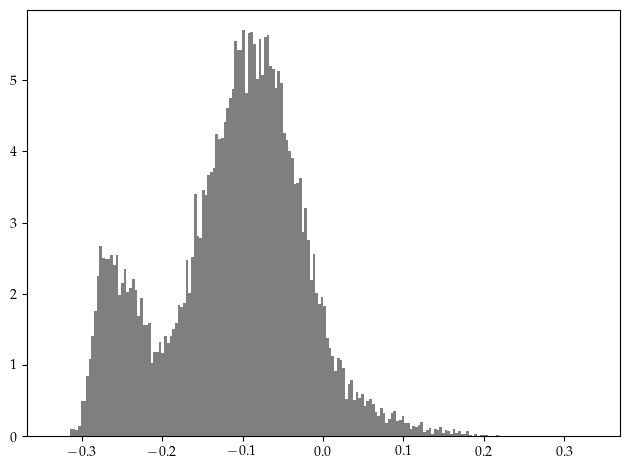

In [10]:
event_samples["chi_eff"] = (event_samples['mass1_source'] * event_samples['spin1_magnitude'] * np.cos(event_samples['spin1_polar_angle']) +
                                 event_samples['mass2_source'] * event_samples['spin2_magnitude'] * np.cos(event_samples['spin2_polar_angle'])) / \
                                 (event_samples['mass1_source'] + event_samples['mass2_source'])
plt.hist(event_samples["chi_eff"], bins=200, density=True, alpha=0.5, label=r'GW230529 $\chi_{\mathrm{eff}}$', color="black")
plt.show()

In [11]:
conv_dict = {"mass1_source":"mass1_source","mass2_source": "mass2_source","redshift":"z","a_1":"spin1_magnitude","tilt1": "spin1_polar_angle","a_2":"spin2_magnitude","tilt2":"spin2_polar_angle"}

_pe = lambda x: event_samples[conv_dict[x]].values.T
costilt1 = np.cos(_pe("tilt1")) ; costilt2 = np.cos(_pe("tilt2"))
z = _pe("redshift") ; a1 = _pe("a_1") ; a2 = _pe("a_2")
theta_pe = np.array([_pe("mass1_source"), _pe("mass2_source"), z, a1, costilt1, a2, costilt2])
theta_pe = np.expand_dims(theta_pe, axis = 2)

lnprob_mass1_source = np.log(1 + _pe('redshift'))
lnprob_mass2_source = np.log(1 + _pe('redshift'))


# cosmo = Cosmology(PLANCK_2018_Ho, PLANCK_2018_OmegaMatter, PLANCK_2018_OmegaRadiation, PLANCK_2018_OmegaLambda)
# cosmo.extend(max_z=np.max(z))
# d_l = cosmo.z2DL(z)
# luminosity_distance = d_l * MPC_CGS # don't remove this from the dictionary
# lnprob_redshift = 2*np.log(luminosity_distance) + np.log(cosmo.z2Dc(z) + (1+z)*cosmo.dDcdz(z))
# importance_pe_lnprob_mass_src = lnprob_mass1_source + lnprob_mass2_source
# spin_sqrd = a1**2
# a1_max = np.max(a1)
# lnprob_spin1spherical = -np.log(4*np.pi*a1_max * np.ones(len(spin_sqrd)))
# spin_sqrd = a2**2
# a2_max = np.max(a2)
# lnprob_spin2spherical = -np.log(4*np.pi*a2_max * np.ones(len(spin_sqrd)))
# importance_pe = lnprob_mass1_source + lnprob_mass2_source + lnprob_redshift + lnprob_spin1spherical + lnprob_spin2spherical
# importance_pe = np.expand_dims(importance_pe, axis=1)
importance_pe = np.zeros((len(event_samples), 1))  # Initialize importance_pe with zeros

print("Shape of theta_pe:", theta_pe.shape)
print("Shape of importance_pe:", importance_pe.shape)

Shape of theta_pe: (7, 23988, 1)
Shape of importance_pe: (23988, 1)


In [12]:
change_vals = [-2.0, 1.0, 4.0]
num_hyperpost = int(len(population_samples["notch_lowmass_scale"])/10) # len(lambda_pop)
num_events = 1
num_dim = 7

mass2_source_arr = np.zeros((len(change_vals), num_hyperpost))
mass1_source_arr = np.zeros((len(change_vals), num_hyperpost))
a1_arr = np.zeros((len(change_vals), num_hyperpost))
costilt1_arr = np.zeros((len(change_vals), num_hyperpost))
a2_arr = np.zeros((len(change_vals), num_hyperpost))
costilt2_arr = np.zeros((len(change_vals), num_hyperpost))

for i in tqdm(range(len(change_vals))):
    # population_samples = pd.read_csv(f"../grid_beta_low/population{change_vals[i]}.csv.gz") #debugging purposes only
    population_samples["w"] = np.ones(len(population_samples)) * -1.0  # Set w to -1.0 for all samples
    population_samples[conv["beta_1"]] = np.ones(len(population_samples)) * change_vals[i]
    lambda_pop = population_samples[[conv[param] for param in requirements]]
    reweighed_samples = np.empty((num_hyperpost, num_events, num_dim))

    for k in range(num_hyperpost):
        weights = np.exp(model_vector(theta_pe, lambda_pop.T[k]) - importance_pe)
        for j in range(num_events):
            index = np.random.choice(len(weights), p=weights.squeeze() / weights.squeeze().sum())
            reweighed_samples[k, j, :] = theta_pe[:, index, j]

    mass1_source, mass2_source, redshift, a1, costilt1, a2, costilt2 = reweighed_samples.squeeze().T
    mass2_source_arr[i] = mass2_source
    mass1_source_arr[i] = mass1_source
    a1_arr[i] = a1
    costilt1_arr[i] = costilt1
    a2_arr[i] = a2
    costilt2_arr[i] = costilt2

100%|██████████| 3/3 [00:10<00:00,  3.60s/it]


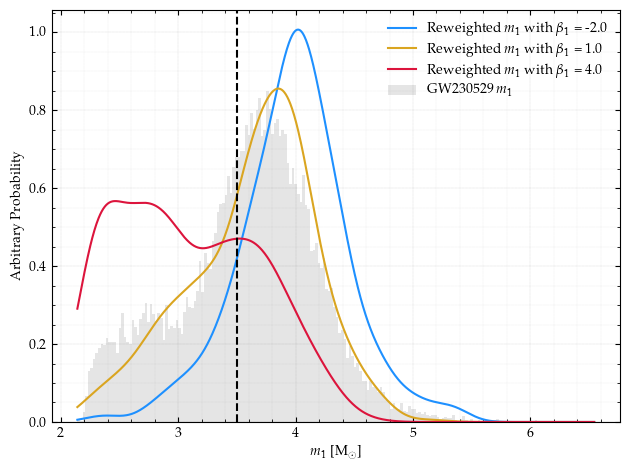

In [13]:
from scipy.stats import gaussian_kde

x = np.linspace(min(event_samples['mass1_source']), max(event_samples['mass1_source']), 1000)

for i in range(mass2_source_arr.shape[0]):
    mass1_source = mass1_source_arr[i]
    kde_mass1 = gaussian_kde(mass1_source)
    kde_values = kde_mass1(x)
    plt.plot(x, kde_values, label=fr"Reweighted $m_1$ with $\beta_1$ = {change_vals[i]:.1f}")

plt.hist(event_samples['mass1_source'], bins=200, density=True, alpha=0.1, label=r'GW230529 $m_1$', color="black")
# plt.xlim(2.3, 2.8)
plt.xlabel(r'$m_1$ [M$_\odot$]')
plt.ylabel("Arbitrary Probability")
plt.utkarshWrapper()
plt.axvline(x=3.5, color='black', linestyle='--', label="EOS Motivated M-TOV")
plt.savefig("plots/PDBGW230529mass1_source_reweighing_beta_1.png", bbox_inches='tight')
plt.show()

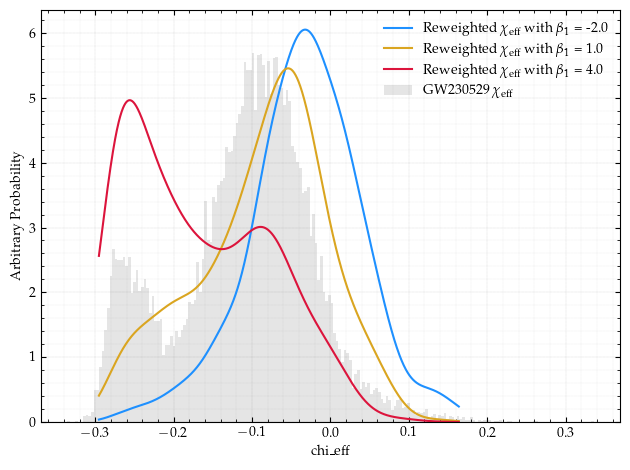

In [14]:
mass_ratio_arr = mass2_source_arr / mass1_source_arr
chi_eff_arr = (mass1_source_arr*a1_arr*(costilt1_arr) + mass2_source_arr*a2_arr*costilt2_arr)/(mass1_source_arr + mass2_source_arr)


from scipy.stats import gaussian_kde

x = np.linspace(np.min(chi_eff_arr), np.max(chi_eff_arr), 1000)

for i in range(chi_eff_arr.shape[0]):
    chi_eff = chi_eff_arr[i]
    kde = gaussian_kde(chi_eff)
    kde_values = kde(x)
    plt.plot(x, kde_values, label=fr"Reweighted $\chi_{{\mathrm{{eff}}}}$ with $\beta_1$ = {change_vals[i]:.1f}")

plt.hist(event_samples["chi_eff"], bins=200, density=True, alpha=0.1, label=r'GW230529 $\chi_{\mathrm{eff}}$', color="black")
plt.xlabel(r'chi_eff')
plt.ylabel("Arbitrary Probability")
plt.utkarshWrapper()
plt.savefig("plots/PDBGW230529chi_eff_source_reweighing_beta_1.png", bbox_inches='tight')
plt.show()

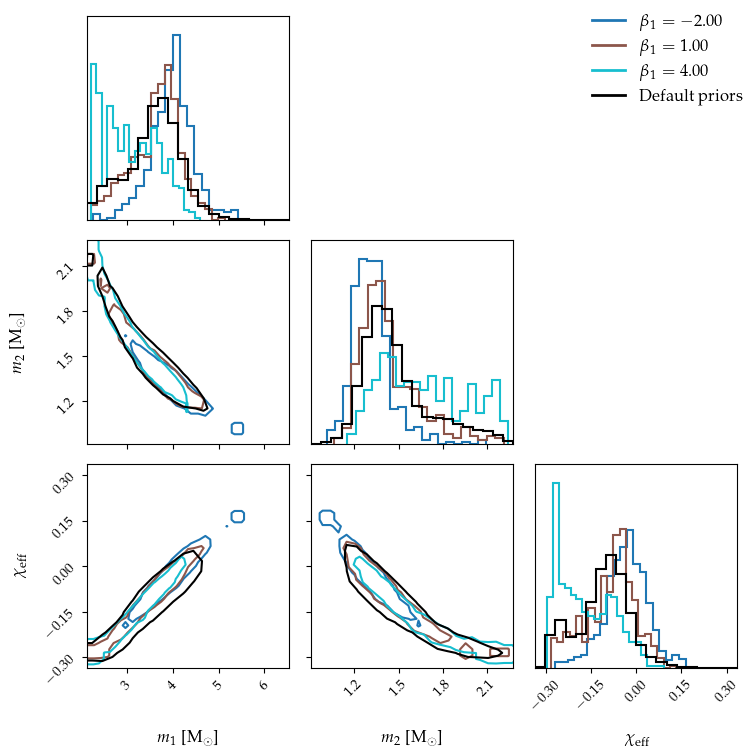

In [15]:
import corner
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

num_betas = mass1_source_arr.shape[0]
corner_labels = [r'$m_1$ [M$_\odot$]', r'$m_2$ [M$_\odot$]', r'$\chi_{\mathrm{eff}}$']
colors = plt.cm.tab10(np.linspace(0, 1, num_betas))
corner_fig = None

# Plot your colored datasets with KDE smoothing
for i in range(num_betas):
    corner_params = np.array([
        mass1_source_arr[i],
        mass2_source_arr[i],
        chi_eff_arr[i]
    ])

    corner_fig = corner.corner(
        corner_params.T,
        fig=corner_fig,
        labels=corner_labels if i == 0 else None,
        show_titles=False,
        label_kwargs={"fontsize": 12},
        plot_density=False,
        plot_datapoints=False,
        hist_kwargs={"histtype": "step", "density": True, "color": colors[i], "linewidth": 1.5},
        plot_contours=True,
        fill_contours=False,
        levels=[0.9],
        contour_kwargs={'colors': [colors[i]], 'linewidths': 1.5},
        smooth=0.5
    )

# Now plot the Default priors dataset in black, smoothed KDE
default_params = np.array([
    event_samples["mass1_source"],
    event_samples["mass2_source"],
    event_samples["chi_eff"]
])

corner_fig = corner.corner(
    default_params.T,
    fig=corner_fig,
    labels=corner_labels,
    show_titles=False,
    label_kwargs={"fontsize": 12},
    plot_density=False,
    plot_datapoints=False,
    hist_kwargs={"histtype": "step", "density": True, "color": "black", "linewidth": 1.5},
    plot_contours=True,
    fill_contours=False,
    levels=[0.9],
    contour_kwargs={'colors': ['black'], 'linewidths': 1.5},
    smooth=0.5
)

# Legend with colors + black for Default priors
legend_elements = [
    Line2D([0], [0], color=colors[i], lw=2, label=fr'$\beta_1 = {change_vals[i]:.2f}$')
    for i in range(num_betas)
] + [Line2D([0], [0], color='black', lw=2, label='Default priors')]

corner_fig.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.savefig("plots/PDBGW230529_HISTcorner_plot_beta_1.png", bbox_inches='tight')
plt.show()


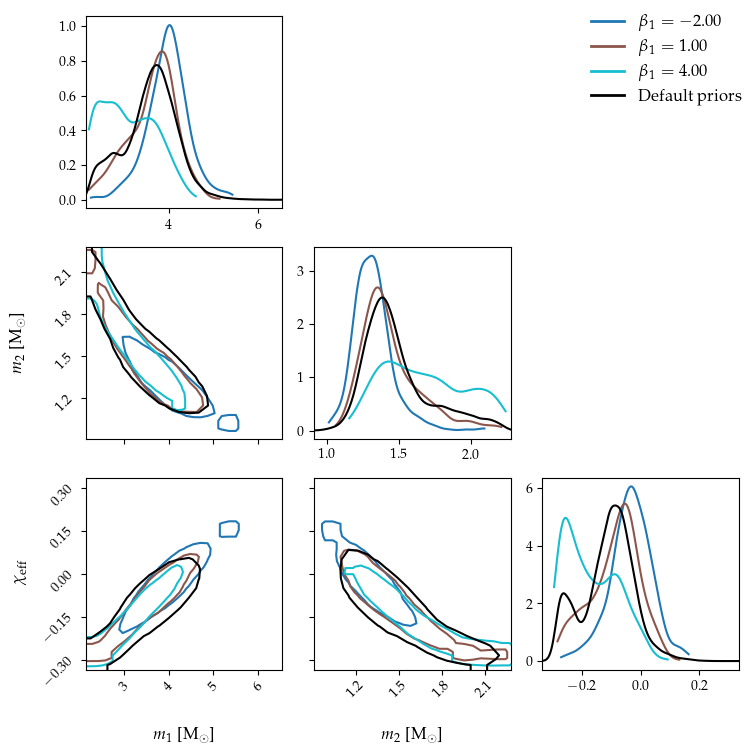

In [16]:
import corner
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

num_betas = mass1_source_arr.shape[0]
corner_labels = [r'$m_1$ [M$_\odot$]', r'$m_2$ [M$_\odot$]', r'$\chi_{\mathrm{eff}}$']
colors = plt.cm.tab10(np.linspace(0, 1, num_betas))
corner_fig = None

# Plot colored datasets WITHOUT 1D histograms (disable them)
for i in range(num_betas):
    corner_params = np.array([
        mass1_source_arr[i],
        mass2_source_arr[i],
        chi_eff_arr[i]
    ])

    corner_fig = corner.corner(
        corner_params.T,
        fig=corner_fig,
        labels=corner_labels if i == 0 else None,
        show_titles=False,
        label_kwargs={"fontsize": 12},
        plot_density=False,
        plot_datapoints=False,
        hist_kwargs={'histtype': 'step', 'alpha': 0},  # make histograms fully transparent
        plot_contours=True,
        fill_contours=False,
        levels=[0.9],
        contour_kwargs={'colors': [colors[i]], 'linewidths': 1.5},
        smooth=1.0,
    )

# Plot Default priors, again disabling 1D histograms
default_params = np.array([
    event_samples["mass1_source"],
    event_samples["mass2_source"],
    event_samples["chi_eff"]
])

corner_fig = corner.corner(
    default_params.T,
    fig=corner_fig,
    labels=corner_labels,
    show_titles=False,
    label_kwargs={"fontsize": 12},
    plot_density=False,
    plot_datapoints=False,
    hist_kwargs={'histtype': 'step', 'alpha': 0},  # fully transparent
    plot_contours=True,
    fill_contours=False,
    levels=[0.9],
    contour_kwargs={'colors': ['black'], 'linewidths': 1.5},
    smooth=1.0,
)

# Remove all 1D histograms by clearing diagonal axes before adding KDEs
n_params = 3
axes = corner_fig.axes

for dim in range(n_params):
    ax = axes[dim * n_params + dim]
    ax.cla()  # clear diagonal axis content completely

def plot_kde_on_axis(ax, data, color):
    kde = gaussian_kde(data)
    x_eval = np.linspace(np.min(data), np.max(data), 200)
    y_eval = kde(x_eval)
    ax.plot(x_eval, y_eval, color=color, lw=1.5)
    ax.set_xlim(np.min(data), np.max(data))

# Plot KDEs for colored betas
for i in range(num_betas):
    for dim in range(n_params):
        ax = axes[dim * n_params + dim]
        data = np.array([
            mass1_source_arr[i],
            mass2_source_arr[i],
            chi_eff_arr[i]
        ])[dim]
        plot_kde_on_axis(ax, data, colors[i])

# Plot KDEs for Default priors (black)
for dim in range(n_params):
    ax = axes[dim * n_params + dim]
    data = default_params[dim]
    plot_kde_on_axis(ax, data, 'black')

# Legend with colors + black for Default priors
legend_elements = [
    Line2D([0], [0], color=colors[i], lw=2, label=fr'$\beta_1 = {change_vals[i]:.2f}$')
    for i in range(num_betas)
] + [Line2D([0], [0], color='black', lw=2, label='Default priors')]

corner_fig.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig("plots/PDBGW230529_KDEcorner_plot_beta_1.png", bbox_inches='tight')
plt.show()


In [17]:
 # population_samples = pd.read_csv("../grid_gamma_low/population2.2.csv.gz")
# population_samples["w"] = np.ones(len(population_samples)) * -1.0  # Set w to -1.0 for all samples
#
#
# a_max_vals = [0.3, 0.5, 0.7, 0.9]
# num_hyperpost = int(len(population_samples["max_spin2_magnitude_mass2_source_0"])/1) # len(lambda_pop)
# num_events = 1
# num_dim = 7
#
#
# mass2_source_arr = np.zeros((len(a_max_vals), num_hyperpost))
#
# for i in tqdm(range(len(a_max_vals))):
#     population_samples["max_spin2_magnitude_mass2_source_0"] = np.ones(len(population_samples)) * a_max_vals[i]
#     population_samples["max_spin2_magnitude_mass2_source_1"] = np.ones(len(population_samples)) * a_max_vals[i]
#     lambda_pop = population_samples[[conv[param] for param in requirements]]
#     reweighed_samples = np.empty((num_hyperpost, num_events, num_dim))
#
#     for k in range(num_hyperpost):
#         weights = np.exp(model_vector(theta_pe, lambda_pop.T[k]) - importance_pe)
#         for j in range(num_events):
#             index = np.random.choice(len(weights), p=weights.squeeze() / weights.squeeze().sum())
#             reweighed_samples[k, j, :] = theta_pe[:, index, j]
#
#     mass1_source, mass2_source, redshift, a1, costilt1, a2, costilt2 = reweighed_samples.squeeze().T
#     mass2_source_arr[i] = mass2_source

In [18]:
# from scipy.stats import gaussian_kde
#
# x = np.linspace(min(event_samples['mass2_source']), max(event_samples['mass2_source']), 1000)
#
# for i in range(mass2_source_arr.shape[0]):
#     mass2_source = mass2_source_arr[i]
#     kde_mass2 = gaussian_kde(mass2_source)
#     kde_values = kde_mass2(x)
#     plt.plot(x, kde_values, label=fr"Reweighted $m_2$ with $a_{{max}}$ = {a_max_vals[i]:.1f}")
#
# plt.hist(event_samples['mass2_source'], bins=200, density=True, alpha=0.5, label=r'GW190814 $m_2$', color="black")
# plt.xlim(2.3, 2.8)
# plt.xlabel(r'$m_2$ [M$_\odot$]')
# plt.utkarshWrapper()
# plt.savefig("mass2_source_reweighing_a_max.pdf", bbox_inches='tight')
# plt.show()